# Lesson 13, Workalong 01: Finding Earthquakes in California

This workalong uses `geopandas` to find earthquakes within California.  It builds from the [lesson 05 warmup](https://github.com/taobrienlbl/advanced_earth_science_data_analysis/blob/8fdbb61bc39b64244f420d446b985a4d27f80df6/lessons/05_multidimensional_arrays_also_plotting/05_warmup_SOLUTION.ipynb), in which we used pandas to find earthquakes from a USGS dataset.  We'll use a similar approach to initially load the same dataset.

In [2]:
""" Import libraries """
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy
import numpy as np

In [3]:
""" Load the usgs dataset """
dataset_path = "https://raw.githubusercontent.com/taobrienlbl/advanced_earth_science_data_analysis/1cc2bc06219f7c15b211629a2aeba7d57e783138/lessons/05_multidimensional_arrays_also_plotting/data/usgs_major_earthquakes_1900-2023.csv"

#file_path_eq6 = r'C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\lesson05\usgs_major_earthquakes_1900-2023.csv'

#read in data file
usgs_pd = pd.read_csv(dataset_path, header = 0, delimiter=',', parse_dates=[0]) 
usgs_pd.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-09-21 21:11:49.950000+00:00,-14.0039,167.1898,188.419,6.1,mww,76.0,26.0,7.076,0.83,...,2023-09-21T23:17:30.631Z,"41 km WSW of Sola, Vanuatu",earthquake,8.86,4.898,0.054,33.0,reviewed,us,us
1,2023-09-20 14:45:58.609000+00:00,-4.5826,-105.6493,10.000,6.0,mww,110.0,208.0,15.828,1.08,...,2023-09-21T21:02:41.950Z,central East Pacific Rise,earthquake,14.99,1.952,0.050,38.0,reviewed,us,us
2,2023-09-18 13:21:23.790000+00:00,26.4336,125.3032,183.483,6.3,mww,113.0,35.0,2.262,1.21,...,2023-09-19T13:29:35.504Z,"180 km N of Hirara, Japan",earthquake,6.53,4.942,0.044,49.0,reviewed,us,us
3,2023-09-13 11:49:15.926000+00:00,-36.2201,-97.9378,10.000,6.1,mww,117.0,37.0,13.309,0.65,...,2023-09-14T11:52:11.466Z,West Chile Rise,earthquake,10.28,1.860,0.050,39.0,reviewed,us,us
4,2023-09-12 11:03:18.873000+00:00,19.2687,121.2178,41.281,6.3,mww,133.0,21.0,4.049,0.96,...,2023-09-18T13:59:24.715Z,"73 km N of Namuac, Philippines",earthquake,8.03,5.112,0.046,46.0,reviewed,us,us


<Axes: >

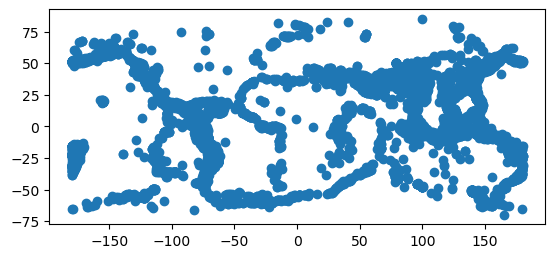

In [4]:
""" Convert the pandas dataframe into a geodataframe """

#convert
usgs_gdf = gpd.GeoDataFrame(usgs_pd, 
                           geometry= gpd.points_from_xy(usgs_pd['longitude'], usgs_pd['latitude']),
                            #could also use gpd.points_from_xy(usgs_pd.longitude, ...
                           crs = "EPSG:4326") #shorthand for lat lon

usgs_gdf.head()

#plot the dataframe

usgs_gdf.plot()

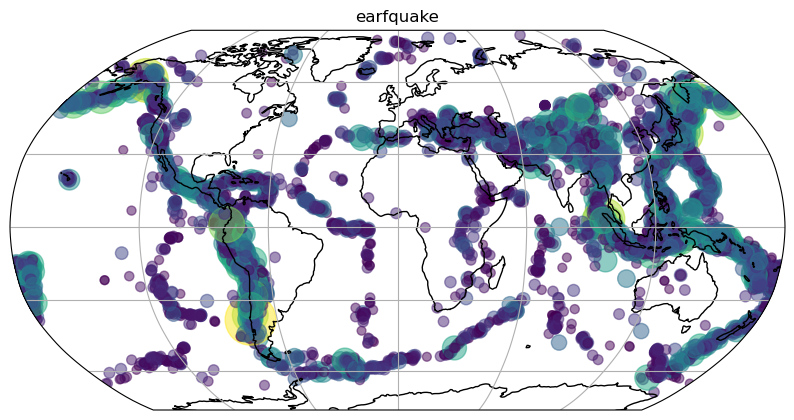

In [5]:
""" Plot the earthquakes by magnitude """
projection = cartopy.crs.Robinson()

#create the plot
fig, ax = plt.subplots(
    figsize = (10,10),
    subplot_kw= {"projection": projection}) # or =dict(projection = projection) ?

#convert projection into PORJ4 string
ax_proj = ax.projection.proj4_init

#convert the usgs data to the projection
usgs_gdf_proj = usgs_gdf.to_crs(ax_proj)
usgs_gdf_proj.plot(ax = ax, 
                   transform = projection,
                   column = "mag", # generates points colored by magnitude
                   markersize = np.exp(usgs_gdf_proj.mag)/10,
                   alpha = 0.5 #transparancy
                   ) 

#add geo features, gridlines
ax.gridlines()
ax.coastlines()


#legend?? what to label?

ax.set_title("earfquake");

## State boundaries

The next step involves filtering by state.  While technically we might be able to determine the location using the "place" column in the dataset, we can do better than that by using a shapefile to define the geospatial region we want to search and then using a point-in-polygon method to find earthquake points taht are within that region.

Note that this shapefile dataset was downloaded from  https://www.sciencebase.gov/catalog/item/52c78623e4b060b9ebca5be5 on Tuesday November 28, 2023 at 1:45pm Eastern.

In [6]:
""" Load the state boundary shapefile. """

state_shapefile_path = "https://github.com/taobrienlbl/advanced_earth_science_data_analysis/raw/09188e9e6a0cf230f8473c0ae95d2e1b9079df3a/lessons/13_geospatial_intro/data/tl_2012_us_state.zip"


state_gdf = gpd.read_file(state_shapefile_path)

state_gdf.head()

,OBJECTID,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,1,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,1.663425e+10,1.167874e+10,+19.8097670,-155.5061027,2.419034e+06,3.268482e+10,"MULTIPOLYGON (((-17361760.204 2164544.588, -17..."
1,2,3,7,05,00068085,05,AR,Arkansas,00,G4000,A,1.347726e+11,2.959210e+09,+34.8955256,-092.4446262,2.656648e+06,2.053261e+11,"POLYGON ((-10515267.713 4101325.818, -10515269..."
2,3,4,8,35,00897535,35,NM,New Mexico,00,G4000,A,3.141611e+11,7.564385e+08,+34.4346843,-106.1316181,2.900368e+06,4.643927e+11,"POLYGON ((-12138963.727 4106855.170, -12138964..."
3,4,4,8,30,00767982,30,MT,Montana,00,G4000,A,3.769636e+11,3.868565e+09,+47.0511771,-109.6348174,4.607246e+06,8.201836e+11,"POLYGON ((-12727480.235 5886876.586, -12727567..."
4,5,1,2,36,01779796,36,NY,New York,00,G4000,A,1.220579e+11,1.923885e+10,+42.9133974,-075.5962723,3.212630e+06,2.637702e+11,"MULTIPOLYGON (((-8866092.533 5160809.769, -886..."


Since this is a dataframe, we can use pandas features to select rows.  I'm going to pull the row where the "STUSPS" column is "CA".

<Axes: >

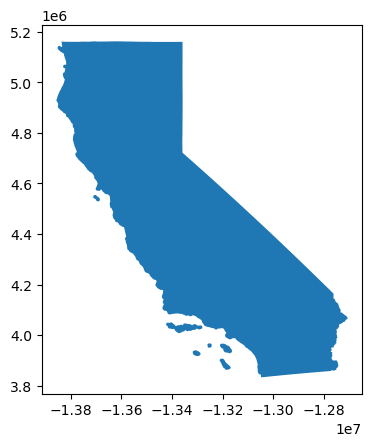

In [7]:
""" Extract the CA row. """
ca_gdf = state_gdf[state_gdf.STUSPS=="CA"] # retrieves where STUSPS is CA

ca_gdf.plot()

This particular shapefile seems to include coastal waters that are also part of the state (note how the islands look like dots).  That might not be great for some analyses, but for our purposes, that's just fine.

C:\Users\janel\AppData\Local\Temp\ipykernel_15372\1987925859.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +proj=robin +a=6378137.0 +lon_0=0 +no_defs +type=c ...
Right CRS: EPSG:4326

  usgs_gdf_proj_clipped2 = gpd.clip(usgs_gdf_proj, ca_gdf_proj) #because of using usgs_gdf_proj


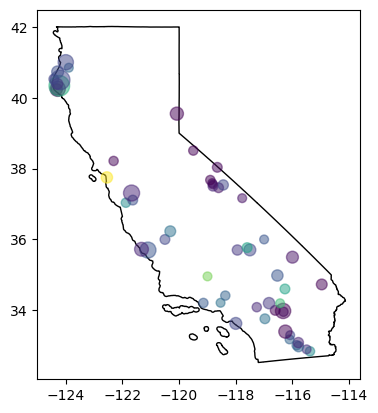

In [8]:
""" Use the CA boundary to clip the earthquakes. """

# convert CA boundary to projection of eq dataset
ca_gdf_proj = ca_gdf.to_crs(usgs_gdf.crs)

#clip the earthwuakes to the CA boundary
usgs_gdf_proj_clipped = gpd.clip(usgs_gdf, ca_gdf_proj) #inputs are (dataset to clip, boundary to clip to)

#see this, same as above but produces error message
usgs_gdf_proj_clipped2 = gpd.clip(usgs_gdf_proj, ca_gdf_proj) #because of using usgs_gdf_proj
    #now, left crs is in robinson, while right is lat/lon



#plot clipped eqs
fig,ax = plt.subplots() #simple plot, not cartopy
ca_gdf_proj.plot(ax=ax, facecolor="none", edgecolor="black") #facecolor colors interior of polygon!

#convert the usgs data to the projection
usgs_gdf_proj_clipped.plot(
                    ax = ax, 
                   #transform = projection, #remember to take this out
                   column = "mag", #if just this, generates points colored by magnitude
                   markersize = np.exp(usgs_gdf_proj.mag)/10,
                   alpha = 0.5 #transparancy
                   ) 

plt.show()


What if we want earthquakes near CA: e.g., within 100 km?  We can inflate (*buffer*) the shapefile boundary to accomplish this.

Note, however, that the shapefile uses a degree-based coordinate system, so we'll *buffer* by degrees, using the fact that 1 degree is approximately 100 km.

In [9]:
""" Inflate the CA shapefile boundary. """


' Inflate the CA shapefile boundary. '

C:\Users\janel\AppData\Local\Temp\ipykernel_15372\4187360430.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ca_boundary_inflated = ca_gdf_proj.buffer(1)


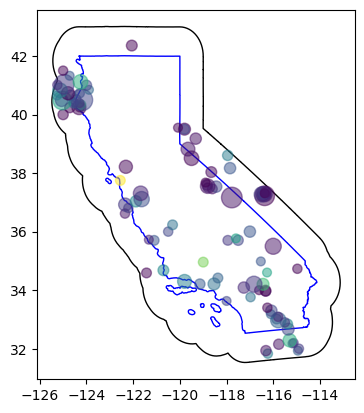

In [10]:
""" Save the inflated boundary to a shapefile for later use. """
#inflate boundary by 1 degree, which is about 100km
ca_boundary_inflated = ca_gdf_proj.buffer(1)

#clip eqs to inflated boundary
usgs_gdf_clipped_inflated = gpd.clip(usgs_gdf, ca_boundary_inflated)



#plot clipped eqs
fig,ax = plt.subplots() #simple plot, not cartopy
ca_gdf_proj.plot(ax=ax, facecolor = 'none', edgecolor = 'blue') #visible org boundary
ca_boundary_inflated.plot(ax=ax, facecolor="none", edgecolor="black") #facecolor colors interior of polygon!

#convert the usgs data to the projection
usgs_gdf_clipped_inflated.plot(
                    ax = ax, 
                   #transform = projection, #remember to take this out
                   column = "mag", #if just this, generates points colored by magnitude
                   markersize = np.exp(usgs_gdf_proj.mag)/10,
                   alpha = 0.5 #transparancy
                   ) 

plt.show()

AttributeError: 'Series' object has no attribute 'cmap'

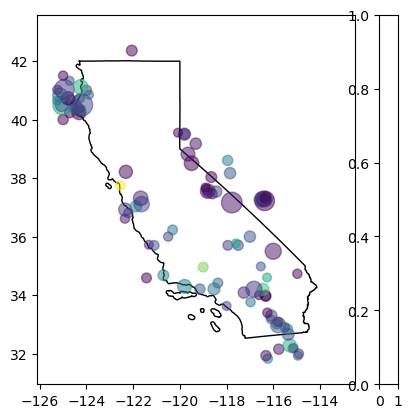

In [11]:
#again but i want just org cali shape

#plot clipped eqs
fig,ax = plt.subplots() #simple plot, not cartopy
ca_gdf_proj.plot(ax=ax, facecolor = 'none', edgecolor = 'black')
ca_boundary_inflated.plot(ax=ax, facecolor="none", edgecolor="none") #facecolor colors interior of polygon!

#convert the usgs data to the projection
usgs_gdf_clipped_inflated.plot(
                    ax = ax, 
                   #transform = projection, #remember to take this out
                   column = "mag", #if just this, generates points colored by magnitude
                   markersize = np.exp(usgs_gdf_proj.mag)/10,
                   alpha = 0.5 #transparancy
                   ) 


#lets add that legend

usgs_sq = usgs_gdf_clipped_inflated.squeeze()
lat = usgs_sq.latitude
lon = usgs_sq.longitude
#colorbar = ax.pcolormesh(lon, lat, usgs_gdf_clipped_inflated.mag)


fig.colorbar(usgs_gdf_clipped_inflated["mag"], ax = ax, label = "k")

plt.show()

print(usgs_gdf_clipped_inflated.mag)
# >:(

In [14]:

# save the inflated boundary to a shapefile
#actually I want the real boundary
ca_gdf_proj.to_file("ca_boundary.shp.zip", driver = "ESRI Shapefile")



In [12]:
""" Save the clipped earthquakes for later use. """

# convert the date column to a string
ca_earthquakes_gdf_tmp = usgs_gdf_clipped_inflated.copy()
ca_earthquakes_gdf_tmp["time"] = ca_earthquakes_gdf_tmp["time"].astype(str)

# save the clipped earthquakes to a shapefile (there will be a warning about column names; this is OK)
ca_earthquakes_gdf_tmp.to_file("ca_earthquakes.shp.zip", driver = "ESRI Shapefile")

C:\Users\janel\AppData\Local\Temp\ipykernel_15372\2661875250.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ca_earthquakes_gdf_tmp.to_file("ca_earthquakes.shp.zip", driver = "ESRI Shapefile")


In [ ]:
print(usgs_gdf_clipped_inflated.mag)

9242     6.80
13370    6.57
9400     6.09
11548    6.33
12431    6.08
         ... 
6686     6.30
6324     7.20
13190    6.50
12606    6.00
4543     6.00
Name: mag, Length: 105, dtype: float64
